# Sheet 4

In [100]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

## 1 Learning with pytorch

(a)

In [101]:
# TODO: manual check of intermediate gradients with torch.autograd.grad
x1 = torch.tensor(1.5, requires_grad=True)
x2 = torch.tensor(0.5, requires_grad=True)
v1 = x1/x2
v2 = torch.sin(v1)
v3 = torch.exp(x2)
v4 = v1-v3
v5 = v2+v4
L = v4*v5
for val in [x1,x2,v1,v2,v3,v4,v5,L]:
    grad = torch.autograd.grad(L, val, create_graph=True)[0]
    print(f"{val.item():.4f}\t {grad.item():.4f}")


1.5000	 3.0118
0.5000	 -13.7240
3.0000	 1.5059
0.1411	 1.3513
1.6487	 -2.8437
1.3513	 2.8437
1.4924	 1.3513
2.0166	 1.0000


(b)

In [102]:
# TODO: Adam steps
# Adam steps
def get_L(x1, x2):
    return (torch.sin(x1/x2) + x1/x2 - torch.exp(x2)) * (x1/x2 - torch.exp(x2))
    
x1 = torch.tensor(1.5, requires_grad=True)
x2 = torch.tensor(0.5, requires_grad=True)
optimizer = torch.optim.Adam([x1], lr=0.1)
x1s = []
n_epochs = 200
for epoch in range(n_epochs):
    x1s.append(x1.item())
    L = get_L(x1, x2)
    L.backward()
    optimizer.step()
    optimizer.zero_grad()

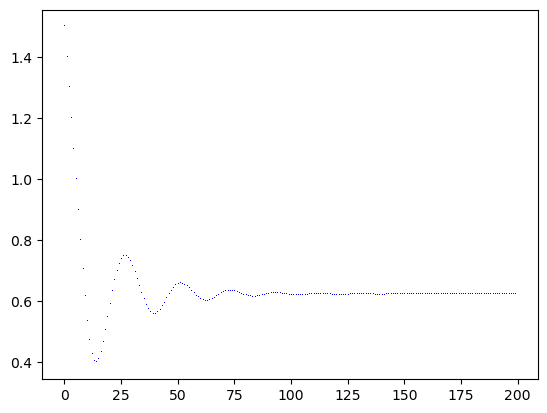

optimal x1 at 0.6207423806190491


In [103]:
# TODO: Plot the loss
its = range(n_epochs)
plt.plot(its, x1s, "b,")
plt.show()
print("optimal x1 at",x1s[-1])

(c)

In [127]:
# TODO: Compute gradients
x1s = np.arange(0,2.01,0.01)
x2 = torch.tensor(0.5, requires_grad=True)
grads = []
for x in x1s:
    x = torch.tensor(x, requires_grad=True)
    L = get_L(x, x2)
    L.backward()
    grads.append(x.grad.item())

grads = np.array(grads)

0.62
agrees up to the precision


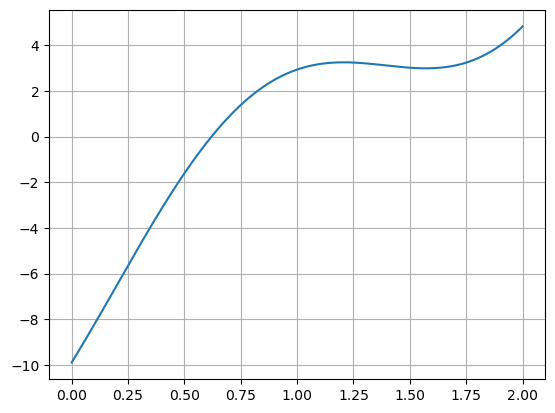

In [132]:
# TODO: Plot gradients and compare to solution for x1 from part (b)
plt.plot(x1s, grads)
plt.grid()
#find the root:
idx = np.argmin(abs(grads))
x0 = x1s[idx]

print(x0)
print("agrees up to the precision")

# 2) Amplitude Regression

In [ ]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data04"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-2-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data04

In [ ]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

(a)

In [ ]:
# TODO: Plot amplitudes

In [ ]:
# TODO: Plot incoming momenta

In [ ]:
# TODO: Plot photon pTs

In [ ]:
# TODO: Plot MET

(b)

In [ ]:
# flatten datasets
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev, -1))
val_datf = np.reshape(val_dat, (nev, -1))
tst_datf = np.reshape(tst_dat, (nev, -1))

In [ ]:
# TODO: Implement preprocessing
def preprocess_x(x_in):
    pass

def preprocess_A(A_in):
    pass

def undo_preprocess_A(A_in):
    pass

In [ ]:
# check that network inputs are O(1)
for i in range(20):
    plt.hist(preprocess_x(trn_datf)[0][:,i], range=(-5,5), alpha=.5, bins=50)
plt.hist(preprocess_A(trn_amp)[0][:,0], range=(-5,5), alpha=.5, bins=50)
plt.show()

In [ ]:
# TODO: Implement dataset class
class amp_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, amp):
        pass

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

In [ ]:
# TODO: create datasets and dataloaders

trn_dataloader = ...
val_dataloader = ...
tst_dataloader = ...

(c)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
# TODO: Implement network
class amp_net(nn.Module):
    
    def __init__(self, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2):
        super(amp_net, self).__init__()
        
        pass

    def forward(self, x):
        pass

In [ ]:
# TODO: create network
model = ...
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

In [ ]:
# take first batch from train loader
x, A = next(iter(trn_dataloader))
print(x.shape, A.shape)

In [ ]:
# TODO: Train network on first batch for 10000 iterations

In [ ]:
# TODO: Plot loss

In [ ]:
# TODO: Plot (A_predicted - A_true) / A_true

(d)

In [ ]:
# TODO: Train network on the full training dataset

In [ ]:
# TODO: Plot loss and amplitude histogram

(e)

In [ ]:
# TODO: create dataloaders with reduced dataset

batch_size = 64
trn_dataloader_reduced = ...
val_dataloader_reduced = ...
tst_dataloader_reduced = ...

In [ ]:
# TODO: Train model on reduced dataset

In [ ]:
# TODO: Evaluate model

In [ ]:
# TODO: Implement your regularization approach, train a model and evaluate it